This is the first notebook I worked on, I was trying to find the slopes for the linear portions of the growth curves.

The results here are not used anymore, as we agreed that the linear behaviour is likely due to multi-scattering effects

Briefly to decribe what is in here, I tried to identify a time value where the linear portion started and then fit a line and compared the results

I skip making further comments to the code

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from findiff import FinDiff, coefficients, Coefficient

In [3]:
print(os.getcwd())

/Users/miguel/Documents/Internship_CENTURI


In [7]:
df = pd.read_csv('data/gc_wt.csv')

In [8]:
df.head()

,Time,A5,B6,C7,D8,E1,E9,F10,G2,G11,H3,Mean
0,0:00:09,0.016,0.019,0.012,0.004,0.011,0.011,0.005,0.013,0.003,0.008,0.0102
1,0:05:09,0.004,0.011,0.004,0.009,0.008,0.012,0.011,0.011,0.009,0.008,0.0087
2,0:10:09,0.004,0.010,0.003,0.009,0.007,0.011,0.011,0.011,0.008,0.007,0.0081
3,0:15:09,0.004,0.010,0.003,0.010,0.007,0.011,0.011,0.011,0.007,0.007,0.0081
4,0:20:09,0.004,0.010,0.003,0.009,0.007,0.010,0.011,0.010,0.006,0.007,0.0077


In [39]:
list(df['Time'].values[np.arange(0,501,100)])

['0:00:09', '8:20:09', '16:40:09', '25:00:09', '33:20:09', '41:40:09']

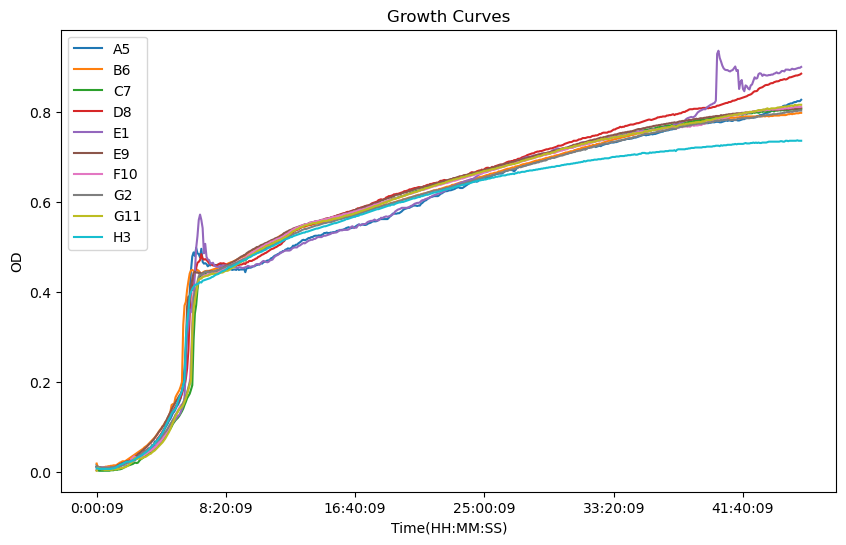

In [10]:
plt.figure(figsize = (10,6))
for i in df.columns[1:-1]:
    plt.plot(df[i], label = i)
    #plt.plot(df[i], marker = 'x', alpha = 0.5)
plt.xticks(np.arange(0,501,100),list(df['Time'].values[np.arange(0,501,100)]))
plt.xlabel('Time(HH:MM:SS)');
plt.ylabel('OD');
plt.title('Growth Curves');
plt.legend();
plt.savefig('gc.png', dpi = 300)

In [6]:
def get_slopes(start, data, end = 0, lon = 10):
    end = len(data)
    step = (end - start)//lon
    interval = np.arange(start, end, step)
    ranges = []
    slopes = []
    for i in range(interval.shape[0]//2):
        temp = (data[interval[::-1][i]] - data[interval[i]]) / (interval[::-1][i] - interval[i])
        ranges.append([interval[i], interval[::-1][i]])
        slopes.append(temp)
    
    return np.array(slopes), np.array(ranges)        

## Calculates the slope of the linear region for every column

In [7]:
slopes = {}
for i in df.columns[1:-1]:
    temp_slope = get_slopes(100, df[i])
    slopes[i] = temp_slope

##### Plot the slope for every column at every interval. Regardless of the column the slopes behaves quite similarly and the average is almost the same

In [8]:
mean_slope = []
for i in slopes.values():
    mean_slope.append(i[0].mean())

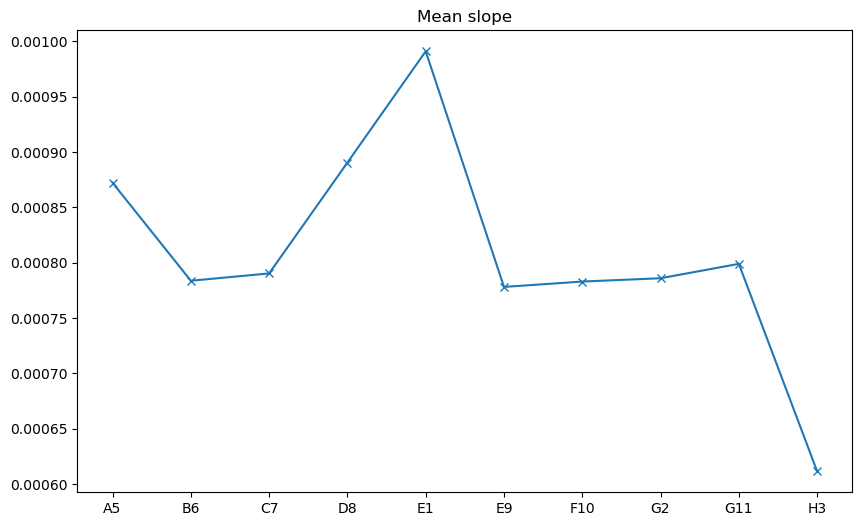

In [9]:
plt.figure(figsize = (10,6))
plt.plot(mean_slope, marker = 'x')
plt.xticks(np.arange(0,len(mean_slope)), labels = slopes.keys());
plt.title('Mean slope');

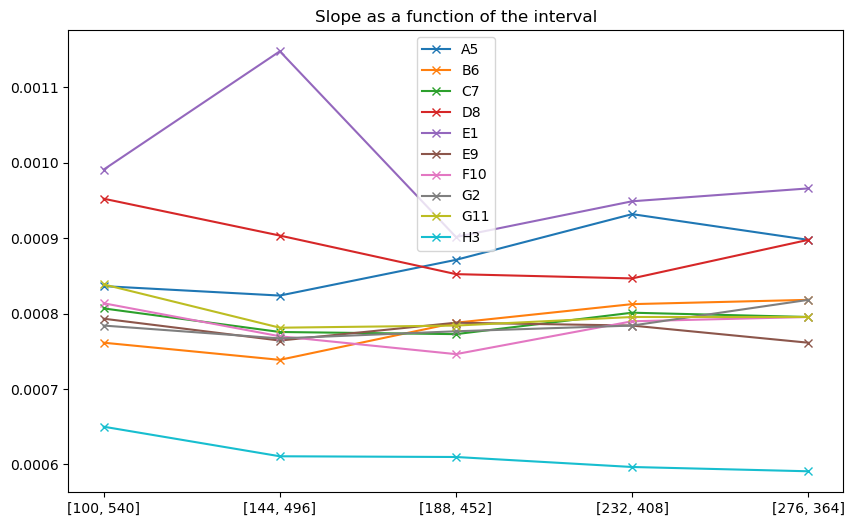

In [10]:
color = ['g', 'r', 'c', 'm', 'k', 'y']
fig, ax = plt.subplots(figsize = (10,6))
c = 0 
for i in df.columns[1:-1]:
    plt.plot(slopes[i][0], marker = 'x', label = i)
#    plt.hlines(slopes[i][0].mean(), xmin = 0, xmax = 5, label = i)
    c += 1
plt.xticks(ticks = np.arange(5), labels = [str(i) for i in slopes['A5'][1].tolist()])
plt.title("Slope as a function of the interval")
plt.legend();


#### Let's use the second derivative to find the portions of the curve that are linear

In [11]:
test = df['G11'].values
dx = 1

In [12]:
d_dx = FinDiff(0, dx, 2)

In [13]:
d_test = d_dx(test)

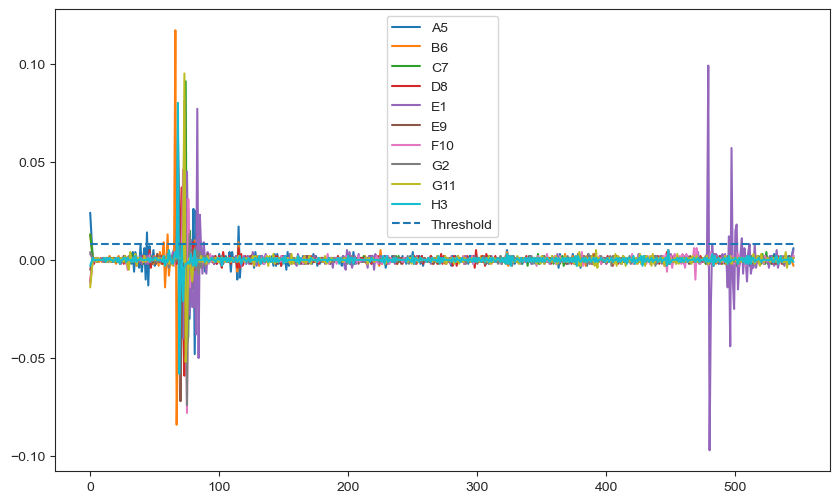

In [53]:
plt.figure(figsize = (10,6))
for i in df.columns[1:-1]:
    temp = df[i].values
    d_temp = d_dx(temp)
    plt.plot(d_temp, label = i)
plt.hlines(8e-3, 0, 546, linestyles = 'dashed', label = 'Threshold')
plt.legend()

In [15]:
def slopes_diff(data, epsilon = 6e-3):
    # Function takes as input the data an returns the slope of the largest linear segement
    # This segment is determined by the second derivative of the data being less than the threshold
    
    # Defines the element to calculate the second derivative
    d_dx = FinDiff(0, dx, 2)
    d_temp = d_dx(data)
    
    # Test the threshold 
    temp_eps = np.argwhere(np.abs(d_temp) > epsilon).reshape(-1)
    if temp_eps[-1] != len(data) -1:
        temp_eps = np.append(temp_eps, len(data)-1)

    max_idx = np.argmax(np.diff(temp_eps))
    start, end = temp_eps[max_idx],  temp_eps[max_idx + 1]
    
    # Calculates the slope
    m = (data[end] - data[start])/ (temp_eps[max_idx + 1] - temp_eps[max_idx])
    interval = [start, end]
    return m, interval
    

In [16]:
diff_slopes = {}
diff_intervals = {}
for i in df.columns[1:-1]:
    temp = df[i].values
    temp_dfslope, temp_dfinterval = slopes_diff(temp)
    diff_slopes[i] = temp_dfslope
    diff_intervals[i] = temp_dfinterval

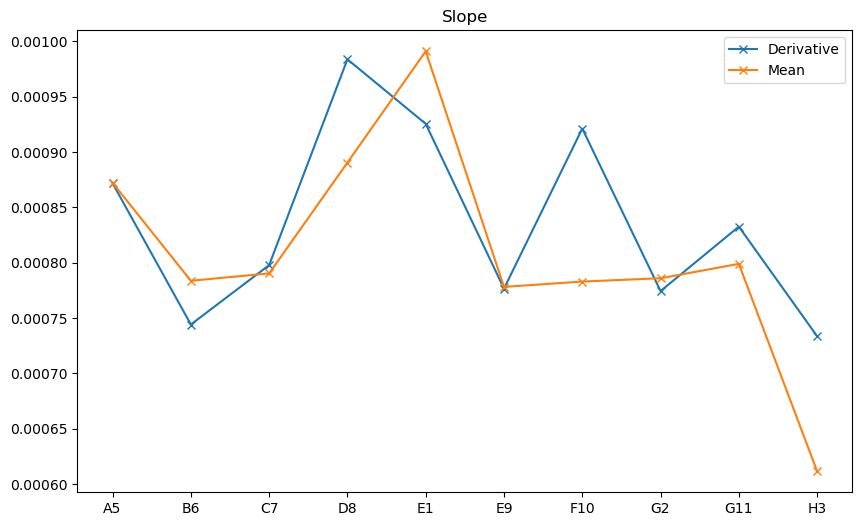

In [17]:
plt.figure(figsize = (10,6))
plt.plot(diff_slopes.values(), marker = 'x', label = 'Derivative')
plt.plot(mean_slope, marker = 'x', label = 'Mean')
plt.xticks(np.arange(0,len(diff_slopes)), labels = diff_slopes.keys());
plt.title('Slope');
plt.legend();

Once the fit intervals have been determined by the two methods I can fit a linear regression and compare the slopes

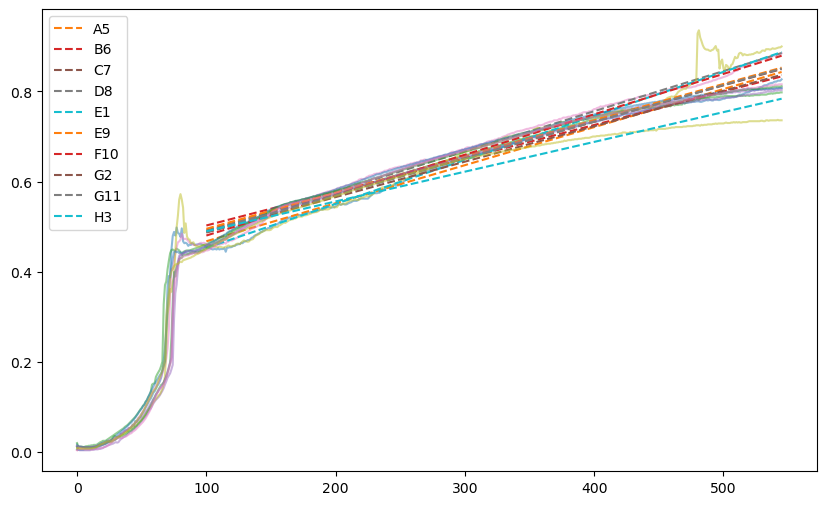

In [18]:
reg_dslope = {}
X = np.arange(100, 546).reshape(-1 , 1)
plt.figure(figsize = (10 ,6))
for i in df.columns[1:-1]:
    temp_X = np.arange(diff_intervals[i][0], diff_intervals[i][1]).reshape(-1, 1)
    y = df[i].values[diff_intervals[i][0]:diff_intervals[i][1]]
    reg = LinearRegression().fit(temp_X, y)
    reg_dslope[i] = [reg.coef_, reg.intercept_, reg.score(temp_X, y)]
    plt.plot(df[i], alpha = 0.5)
    plt.plot(X, reg.predict(X), '--', label = i)

plt.legend();

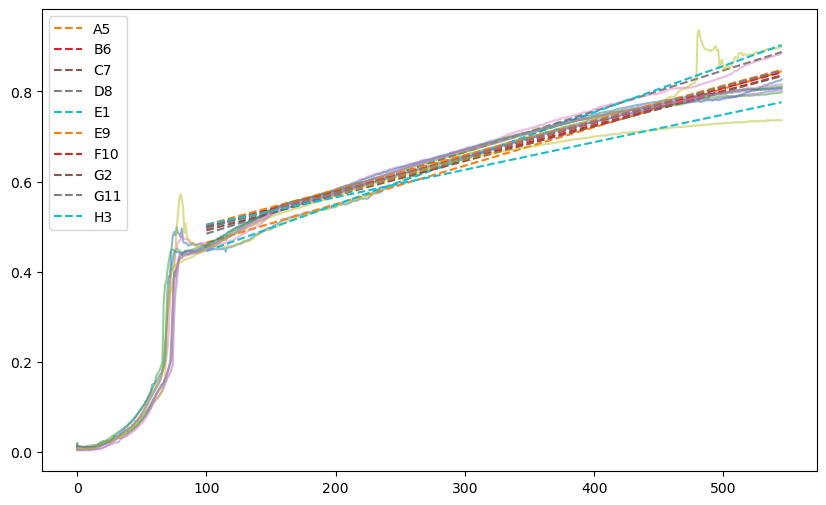

In [19]:
reg_slope = {}
plt.figure(figsize = (10 ,6))
for i in df.columns[1:-1]:
    X = np.arange(100, 546).reshape(-1 , 1)
    y = df[i].values[100:]
    reg = LinearRegression().fit(X, y)
    reg_slope[i] = [reg.coef_, reg.intercept_, reg.score(X, y)]
    plt.plot(df[i], alpha = 0.5)
    plt.plot(X, reg.predict(X), '--', label = i)

plt.legend();

In [20]:
regression_scores = [[reg_slope[i][2], reg_dslope[i][2]] for i in df.columns[1:-1]]
regression_slopes = [[reg_slope[i][0][0], reg_dslope[i][0][0]] for i in df.columns[1:-1]]
regression_slopes = np.array(regression_slopes)


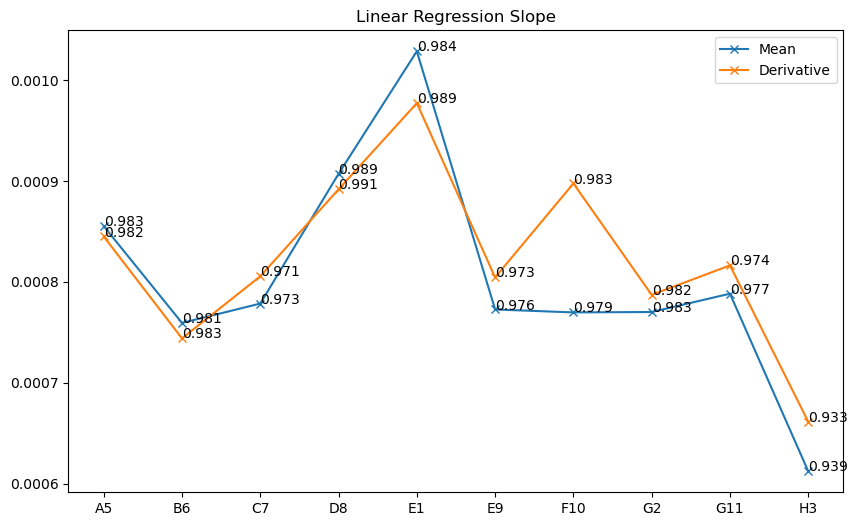

In [21]:
x_range = np.arange(regression_slopes.shape[0])

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(regression_slopes[:,0], marker = 'x', label = 'Mean')
plt.plot(regression_slopes[:,1], marker = 'x', label = 'Derivative')
plt.xticks(x_range, df.columns[1:-1]);

for index in range(regression_slopes.shape[0]):
    ax.text(x_range[index], regression_slopes[index, 0], '{:.3f}'.format(regression_scores[index][0]), size=10)
    ax.text(x_range[index], regression_slopes[index, 1], '{:.3f}'.format(regression_scores[index][1]), size=10)

plt.title('Linear Regression Slope');
plt.legend();

Let's try a logistic regression to see how well it fits the model, even accounting for the linear part

In [22]:
import curveball

In [23]:
def hour_to_sec(x):
    temp = x.strip().split(':')
    return float(temp[0])*60*60 + float(temp[1])*60 + float(temp[2]) 

In [24]:
col = 'G11'
temp_df = df[['Time', col]].copy()
#temp_df['Time'] = temp_df['Time'].map(hour_to_sec)
temp_df['Time'] = np.arange(temp_df.shape[0])
temp_df.rename(columns={col:'OD'}, inplace = True)

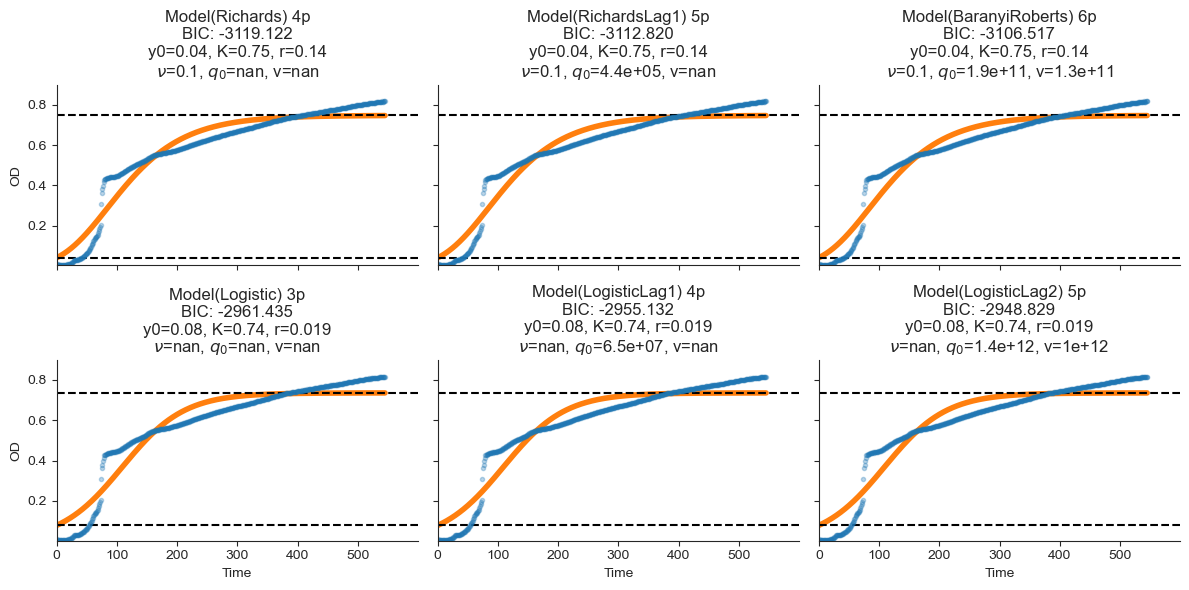

In [25]:
models, fig, ax = curveball.models.fit_model(temp_df, PLOT=True, PRINT=False)

Curveball doesn't do a good job at fitting the data. I will use 

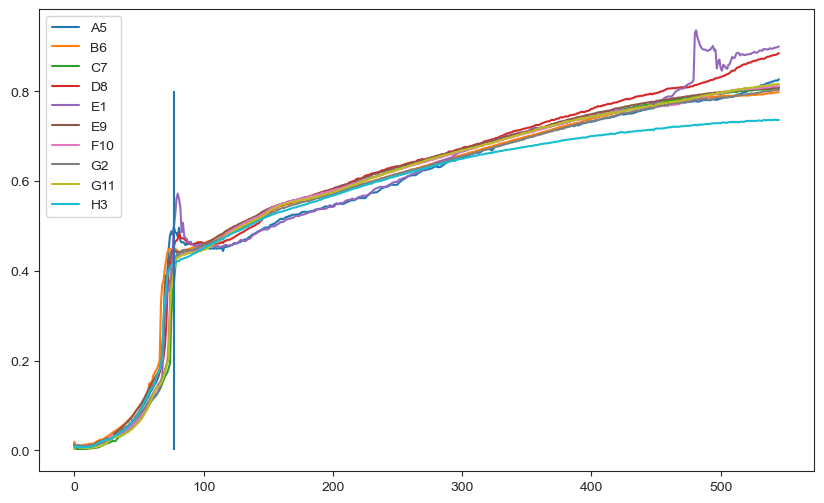

In [26]:
fig = plt.figure(figsize = (10,6))
for i in df.columns[1:-1]:
    plt.plot(df[i], label = i)
    #plt.plot(df[i], marker = 'x', alpha = 0.5)
plt.vlines(77, 0, 0.8)
plt.legend();

Inspectioning the plot only by looking at it, I establish a cutoff until index 77. I will fit an exponential to this data

In [60]:
threshold_idx = 70

In [28]:
import scipy.optimize as optimize

In [29]:
def exponential(x, A, t, b):
    return A * np.exp(t * x) + b

In [61]:
X = np.arange(threshold_idx)
y = df['E1'].values[:threshold_idx]
p0 = (3e-1, 5e-2, 0)
params, cv = optimize.curve_fit(exponential, X, y, p0)

In [63]:
params

array([0.00622067, 0.0486957 , 0.00059545])

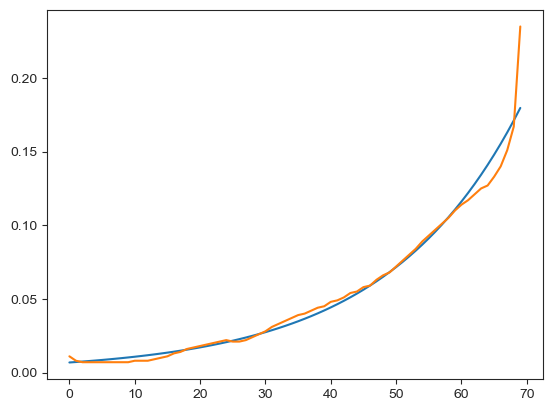

In [62]:
A, t, b = params 
plt.plot(exponential(X, A, t, b))
plt.plot(y)

regression_slopes colum 1 corresponds to the slopes found by using the derivative

In [65]:
grid = np.zeros((8,12))

In [67]:
alph_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':3, 'F':5, 'G':6, 'H':7}

In [71]:
for i, j in enumerate(df.columns[1:-1]):
    row, col = alph_dict[j[0]], int(j[1:])
    grid[row, col] = regression_slopes[i,1]

In [73]:
import seaborn as sns

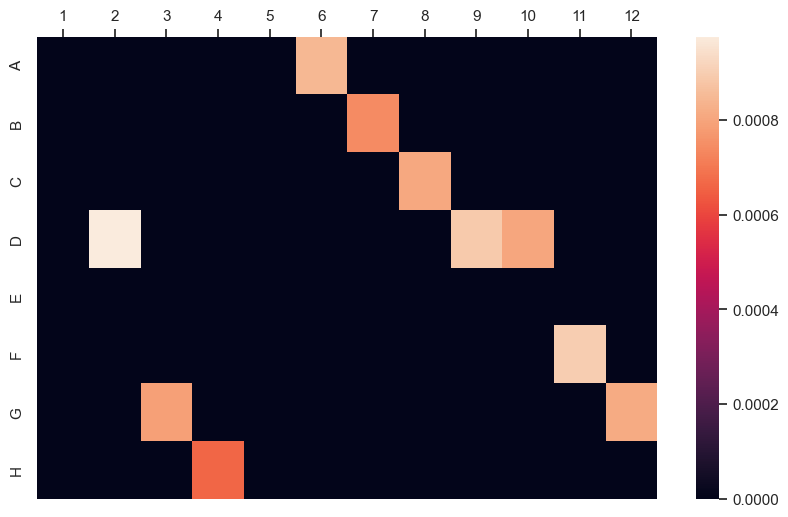

In [108]:
sns.set(rc={"figure.figsize":(10, 6)})
ax = sns.heatmap(grid, linewidth = 0);
ax.set_xticklabels(np.arange(1,13));
ax.set_yticklabels(alph_dict.keys());
ax.xaxis.tick_top()
ax.set_title('Slopes');